In [13]:
import os
import json
import re
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns

Extract the answers and question tags in the json file in order, and directly output the contents of answers and question

In [2]:
import json

with open(r"D:\UNSW life\9444\【fAshIon】A100\【AiDLab】A100\AAT\label\AAT.json", 'r') as f:
    data = json.load(f)

num_items = 0
answers_count = 0
questions_count = 0

for item in data:
    answers = item.get('answers', [])
    questions = item.get('question', [])
       
    num_items += 1

    answers_count += len(answers)
    questions_count += len(questions)

print(f"There are {num_items} items in total")
print(f"There are {answers_count} answers in total")
print(f"There are {questions_count} questions in total")

There are 100 items in total
There are 500 answers in total
There are 483 questions in total


Extract the number from each answers and questions string and use this number to match the image file name in the dataset

In [3]:
with open(r"D:\UNSW life\9444\【fAshIon】A100\【AiDLab】A100\AAT\label\AAT.json", 'r') as f:
    data = json.load(f)

# A dictionary for storing file names and tags. Each file name corresponds to a tag list.
filename_to_label = {}

# Regular expression to extract the number
pattern = re.compile(r'(\d{3}[AQ]\d{2})')

for item in data:
    answers = item.get('answers', [])
    questions = item.get('question', [])
    
    for label in answers + questions:
        match = pattern.search(label)
        if match:
            file_id = match.group(1)
            
            # If the file ID does not exist in the dictionary, initialize it to an empty list
            if file_id not in filename_to_label:
                filename_to_label[file_id] = []
            
            filename_to_label[file_id].append(label)


for filename, labels in filename_to_label.items():
    labels_str = ", ".join(labels)
    print(f"{filename}.jpg: {labels_str}")

num_images = len(filename_to_label)
print(f"There are {num_images} images in total")


001A03.jpg: Shoes/Heels_001A03
001A01.jpg: Shoes/Heels_001A01
001A02.jpg: Shoes/Heels_001A02
001A04.jpg: Shoes/Heels_001A04
001A10.jpg: Shoes/Heels_001A10
001Q01.jpg: Clothings/Outwear_001Q01
001Q02.jpg: Clothings/Dresses_001Q02
001Q03.jpg: Bags/CrossBody_001Q03
001Q04.jpg: Accessories/Watches_001Q04
001Q05.jpg: Accessories/Earrings_001Q05
002A10.jpg: Bags/Shoulder_002A10
002A02.jpg: Bags/Shoulder_002A02
002A01.jpg: Bags/Shoulder_002A01
002A03.jpg: Bags/Shoulder_002A03
002A04.jpg: Bags/Shoulder_002A04
002Q01.jpg: Clothings/Outwear_002Q01
002Q02.jpg: Clothings/Dresses_002Q02
002Q03.jpg: Shoes/Heels_002Q03
002Q04.jpg: Accessories/Earrings_002Q04
002Q05.jpg: Accessories/Necklaces_002Q05
003A01.jpg: Clothings/Tops_003A01
003A02.jpg: Clothings/Tops_003A02
003A10.jpg: Clothings/Tops_003A10
003A03.jpg: Clothings/Tops_003A03
003A04.jpg: Clothings/Tops_003A04
003Q01.jpg: Clothings/Outwear_003Q01
003Q02.jpg: Clothings/Trousers_003Q02
003Q03.jpg: Bags/TopHandle_003Q03
003Q04.jpg: Accessories/Legw

First, let’s count how many main categories there are.

In [4]:
with open(r"D:\UNSW life\9444\【fAshIon】A100\【AiDLab】A100\AAT\label\AAT.json", 'r') as f:
    data = json.load(f)

main_categories = set()

for item in data:
    answers = item.get('answers', [])
    questions = item.get('question', [])

    for label in answers + questions:
        main_category = label.split('/')[0]  
        main_categories.add(main_category)   # Add to the collection (automatically remove duplicates)
        
# Convert the main category collection into an ordered list
labellist = sorted(list(main_categories))

print(f"Total number of main categories: {len(main_categories)}")
print("Main category list:", main_categories)


Total number of main categories: 4
Main category list: {'Bags', 'Accessories', 'Shoes', 'Clothings'}


View an image and tags

The label for this image is Accessories
Total number of images in the dataset: 983


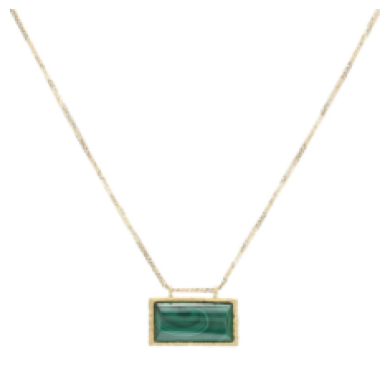

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

labellist = ['Shoes', 'Clothings', 'Bags', 'Accessories']

class FashionDataset(Dataset):
    def __init__(self, images_dir, filename_to_label, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.filename_to_label = filename_to_label
        self.file_ids = list(filename_to_label.keys())

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        file_id = self.file_ids[idx]
        labels = self.filename_to_label[file_id]  
        main_category = labels[0].split('/')[0] 
        label = labellist.index(main_category)

        image_id = file_id + ".jpg"
        img_path = f"{self.images_dir}/{image_id}"
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

images_dir = "D:/UNSW life/9444/【fAshIon】A100/【AiDLab】A100/AAT/image"
dataset = FashionDataset(images_dir, filename_to_label, transform=transform)

# Divide the dataset
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

image_batch, label_batch = next(iter(trainloader))

# Randomly select an index and display the image and label
index = random.randint(0, len(image_batch) - 1)
imagedemo = image_batch[index].permute(1, 2, 0)
imagedemolabel = label_batch[index]

plt.imshow(imagedemo)
plt.axis('off')
print(f'The label for this image is {labellist[imagedemolabel]}')

print(f"Total number of images in the dataset: {len(dataset)}")


In [6]:
image, label = next(iter(trainloader))
image.shape
label

tensor([2, 2, 1, 3, 3, 3, 1, 3, 2, 0, 3, 0, 2, 1, 0, 1, 3, 3, 1, 1, 3, 0, 1, 1,
        3, 1, 1, 2, 3, 3, 1, 2, 1, 3, 3, 1, 1, 3, 3, 0, 1, 2, 2, 3, 3, 1, 1, 1,
        3, 3, 2, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 1, 0, 1])

#### label contains the labels corresponding to the 64 images in image

| Marking number | description |
| --- | --- |
| 0 | Clothings |
| 1 | Bags|
| 2 | Accessories|
| 3 | Shoes|

In [7]:
# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Load the pre-trained ResNet18 model and modify the last layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(labellist))
model = model.cuda() if torch.cuda.is_available() else model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}")

torch.save(model.state_dict(), 'resnet_fashion_model.pth')
print("Model saved as resnet_fashion_model.pth")


d:\setting\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\setting\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 0.49296002892347485
Epoch 2/20, Loss: 0.2172075561605967
Epoch 3/20, Loss: 0.1213940422122295
Epoch 4/20, Loss: 0.04298683542471666
Epoch 5/20, Loss: 0.041866456624120474
Epoch 6/20, Loss: 0.04430786457557518
Epoch 7/20, Loss: 0.09846196008416322
Epoch 8/20, Loss: 0.05944880850326557
Epoch 9/20, Loss: 0.028377643069968775
Epoch 10/20, Loss: 0.07638630270957947
Epoch 11/20, Loss: 0.049508858328828446
Epoch 12/20, Loss: 0.02965619185796151
Epoch 13/20, Loss: 0.0439578599941272
Epoch 14/20, Loss: 0.053331898525357246
Epoch 15/20, Loss: 0.03538640592103967
Epoch 16/20, Loss: 0.02347969374834345
Epoch 17/20, Loss: 0.012123981383270942
Epoch 18/20, Loss: 0.005867371917702258
Epoch 19/20, Loss: 0.002452186165520778
Epoch 20/20, Loss: 0.0018416147683568012
Model saved as resnet_fashion_model.pth


In [8]:
model.eval()  
all_preds = []
all_labels = []

with torch.no_grad():  
    for images, labels in testloader: 
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f"Test set accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)


Test set accuracy: 0.9543147208121827
Confusion Matrix:
 [[41  0  0  0]
 [ 0 63  1  0]
 [ 0  1 28  1]
 [ 0  4  2 56]]


In [9]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):

        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        self.best_loss = val_loss


d:\setting\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\setting\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\setting\python\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Start training
Number of training set learning times: 1/50.. Training error: 1.311.. Test error:0.028.. Model classification accuracy:0.022
Number of training set learning times: 2/50.. Training error: 0.883.. Test error:0.020.. Model classification accuracy:0.027
Number of training set learning times: 3/50.. Training error: 0.737.. Test error:0.016.. Model classification accuracy:0.028
Number of training set learning times: 4/50.. Training error: 0.643.. Test error:0.015.. Model classification accuracy:0.028
Number of training set learning times: 5/50.. Training error: 0.579.. Test error:0.013.. Model classification accuracy:0.029
Number of training set learning times: 6/50.. Training error: 0.529.. Test error:0.012.. Model classification accuracy:0.029
Number of training set learning times: 7/50.. Training error: 0.507.. Test error:0.011.. Model classification accuracy:0.029
Number of training set learning times: 8/50.. Training error: 0.514.. Test error:0.011.. Model classification 

C:\Users\60960\AppData\Local\Temp\ipykernel_35868\3285737149.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


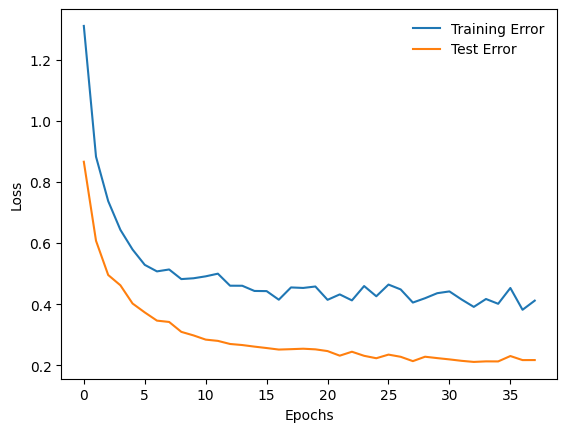

Model saved tofinal_trained_model.pth


In [10]:
# labellist = ['Shoes', 'Clothings', 'Bags', 'Accessories']

# Define the model and add Dropout
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  
            nn.Linear(self.model.fc.in_features, len(labellist)),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

# Set up the device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier().to(device)

# Define the loss function and optimizer, and set weight decay
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.model.fc.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Data Augmentation and Data Loaders
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = FashionDataset(images_dir, filename_to_label, transform=transform)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = FashionDataset(images_dir, filename_to_label, transform=test_transform)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define early stopping mechanism
early_stopping = EarlyStopping(patience=10, delta=0.01)  

epochs = 50
train_losses, test_losses = [], []

print('Start training')
for e in range(epochs):
    running_loss = 0
    model.train()
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradient
        optimizer.zero_grad()
        
        # Forward propagation, calculation of loss and backward propagation
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    test_loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            test_loss += criterion(log_ps, labels).item()
            
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    train_loss = running_loss / len(trainloader)
    test_loss = test_loss / len(testloader)
    accuracy = accuracy / len(testloader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"Number of training set learning times: {e+1}/{epochs}.. "
          f"Training error: {running_loss/len(trainloader):.3f}.. "
          f"Test error:{test_loss/len(testloader):.3f}.. "
          f"Model classification accuracy:{accuracy/len(testloader):.3f}")

    early_stopping(test_loss)
    if early_stopping.early_stop:
        print("Early stop trigger, stop training")
        break

model.load_state_dict(torch.load('best_model.pth'))

plt.plot(train_losses, label='Training Error')
plt.plot(test_losses, label='Test Error')
plt.legend(frameon=False)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

final_model_path = "final_trained_model.pth" 
torch.save(model.state_dict(), final_model_path)
print(f"Model saved to{final_model_path}")

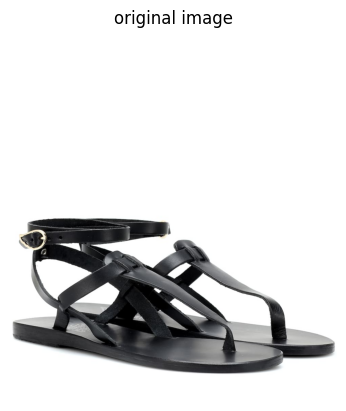

Prediction results：Shoes


In [11]:
def predict_image(image_path, model, labellist):
    image = Image.open(image_path).convert('RGB')
    
    plt.imshow(image)
    plt.axis('off') 
    plt.title("original image")
    plt.show()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0) 
    
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.cuda() if torch.cuda.is_available() else image_tensor
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        label = labellist[predicted.item()]
        
    print(f"Prediction results：{label}")

predict_image("D:/UNSW life/9444/【fAshIon】A100/【AiDLab】A100/AAT/P00128275.jpg", model, labellist)


              precision    recall  f1-score   support

       Shoes       0.99      0.95      0.97       183
   Clothings       0.65      0.99      0.78       298
        Bags       0.99      0.79      0.88       169
 Accessories       0.91      0.59      0.71       333

    accuracy                           0.81       983
   macro avg       0.89      0.83      0.84       983
weighted avg       0.86      0.81      0.81       983



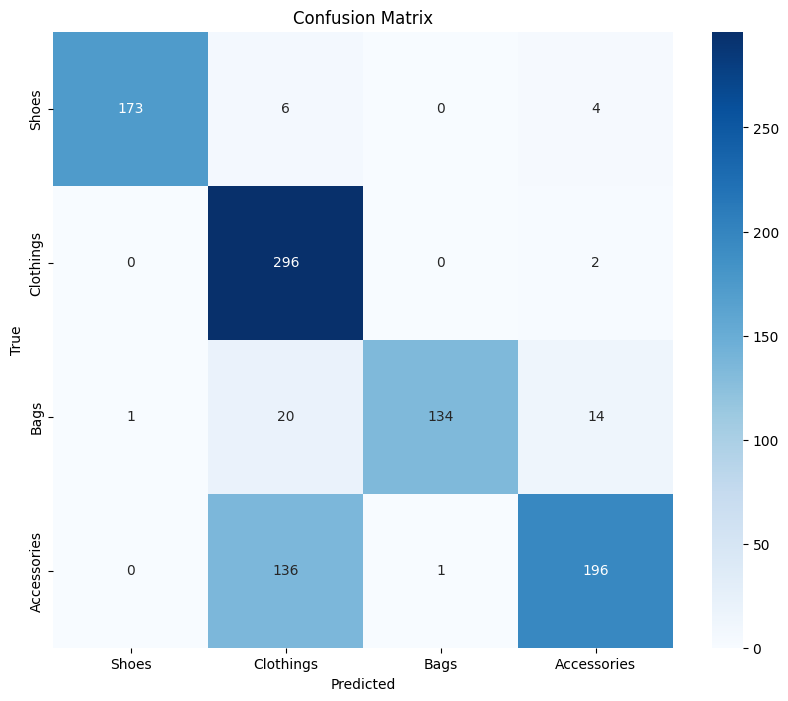

In [14]:
# Get the model prediction results
true_labels = []
pred_labels = []

model.eval()  
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, preds = torch.max(output, 1)
        
        true_labels.extend(labels.cpu().numpy()) 
        pred_labels.extend(preds.cpu().numpy())

report = classification_report(true_labels, pred_labels, target_names=labellist, digits=2)
print(report)


labels = ['Shoes', 'Clothings', 'Bags', 'Accessories']

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

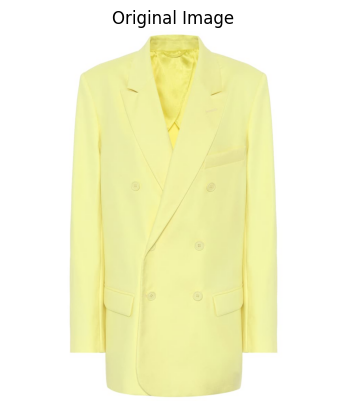

Image: D:/UNSW life/9444/【fAshIon】A100/【AiDLab】A100/LAT/image\P00422687.jpg | Prediction: Clothings


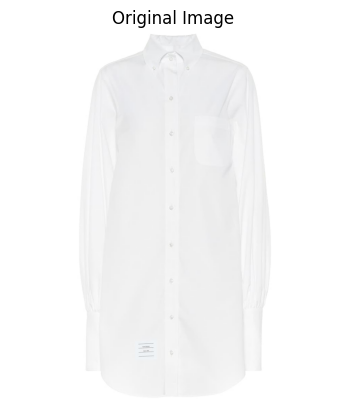

Image: D:/UNSW life/9444/【fAshIon】A100/【AiDLab】A100/LAT/image\P00469654.jpg | Prediction: Clothings


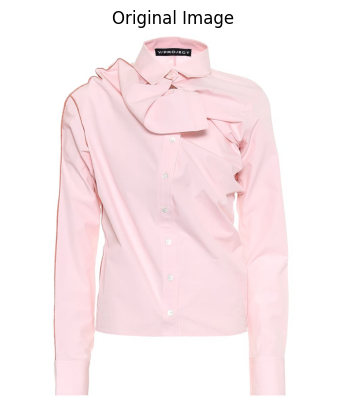

Image: D:/UNSW life/9444/【fAshIon】A100/【AiDLab】A100/LAT/image\P00458020.jpg | Prediction: Clothings


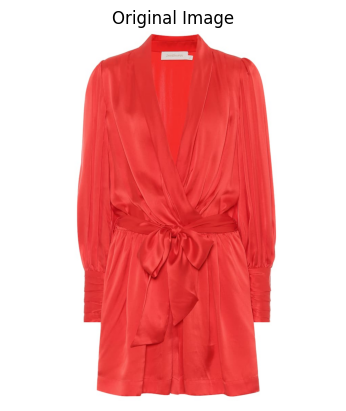

Image: D:/UNSW life/9444/【fAshIon】A100/【AiDLab】A100/LAT/image\P00457672.jpg | Prediction: Clothings


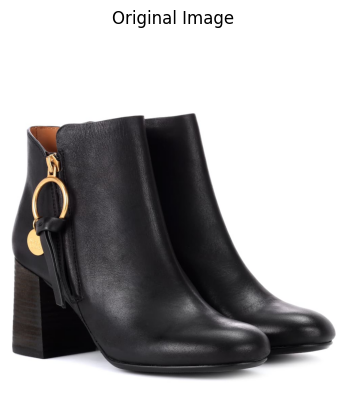

Image: D:/UNSW life/9444/【fAshIon】A100/【AiDLab】A100/LAT/image\P00358320.jpg | Prediction: Shoes


In [15]:
def predict_random_images_from_folder(folder_path, model, labellist, num_images=5):
    image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.jpg'))]
    selected_paths = random.sample(image_paths, num_images)
    
    model.eval()
    with torch.no_grad():
        for image_path in selected_paths:
            image = Image.open(image_path).convert('RGB')
            plt.imshow(image)
            plt.axis('off')
            plt.title("Original Image")
            plt.show()

            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            image_tensor = transform(image).unsqueeze(0).to(device) 

            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            label = labellist[predicted.item()]

            print(f"Image: {image_path} | Prediction: {label}")


folder_path = "D:/UNSW life/9444/【fAshIon】A100/【AiDLab】A100/LAT/image"
predict_random_images_from_folder(folder_path, model, labellist, num_images=5)